### installation of tangelo

In [4]:
#pip install git+https://github.com/goodchemistryco/Tangelo.git@develop 
#pip install qiskit qiskit-aer qulacs amazon-braket-sdk Pennylane 

### translate circuit

In [5]:
from tangelo.linq import translate_circuit

In [6]:
from qiskit import QuantumCircuit

In [7]:
qc = QuantumCircuit(2)

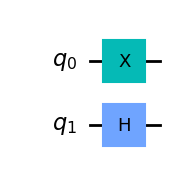

In [8]:
qc.x(0)
qc.h(1)
qc.draw()

In [13]:
qc_tangero = translate_circuit(qc, 'tangelo', 'qiskit')
print(qc_tangero)


Circuit object. Size 2 

X         target : [0]   
H         target : [1]   



### molecule info

In [14]:
beh2 = [("Be", (0.0, 0.0, 0.0)),("H", (1.326, 0.0, 0.0)),("H",(-1.326, 0.0, 0.0))]

In [32]:
basis_sets = [
    "STO-3G",       # Simple zeta, minimal basis.
    "3-21G",        # Double zeta.
    "6-31G",        # Double zeta with more Gaussian primitives.
    "6-31G(d,p)",   # Polarization functions (+ 5 d-orbitals for all atoms except H, +3 p-orbitals for H atoms) added.
    "6-311G(d,p)",  # Triple zeta with polarization functions.
    "6-311+G(d,p)", # Triple zeta with polarization functions and diffuse functions.
    "cc-pvqz",      # Quadruple zeta.
    "cc-pv5z"       # Quintuple zeta.
]

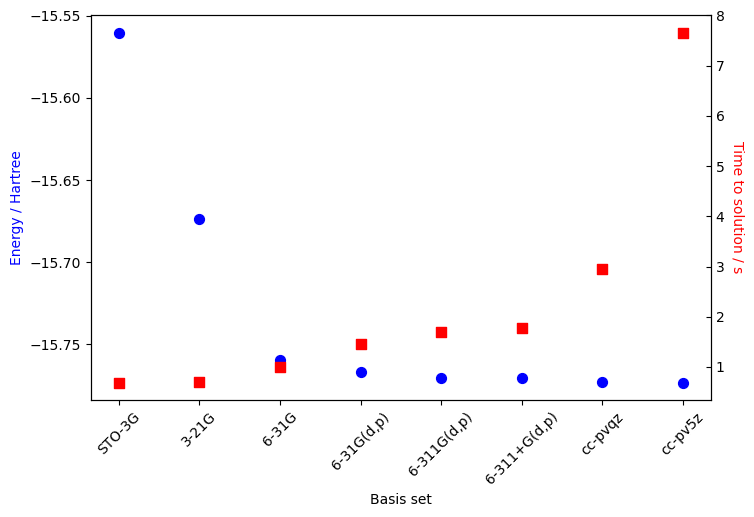

In [33]:
import time
import matplotlib.pyplot as plt

mf_energies = list()
mf_times = list()

# Perform a Mean-Field calculation for each basis set.
for bs in basis_sets:
    
    # Measure execution time.
    start = time.time()
    scan_basis_mol = SecondQuantizedMolecule(beh2, basis=bs)
    end = time.time()
    
    mf_energies.append(scan_basis_mol.mf_energy)
    mf_times.append(end-start)

# Create the matplotlib figure.
fig, ax = plt.subplots(figsize=(8,5))

# Plot the energies.
ax.set_xticks(range(len(basis_sets)), basis_sets, rotation=45)
ax.set_xlabel("Basis set")
ax.set_ylabel("Energy / Hartree", color="b")
ax.scatter(range(len(basis_sets)), mf_energies, marker="o", s=50, color="b")

# Plot the time to solution.
ax_time = ax.twinx()
ax_time.scatter(range(len(basis_sets)), mf_times, marker="s", s=50, color="r")
ax_time.set_ylabel("Time to solution / s", color="r", rotation=270, va="bottom")

# Show the graph.
plt.tick_params(axis="both", direction="in")
plt.show()

In [87]:
from tangelo import SecondQuantizedMolecule
from tangelo.toolboxes.molecular_computation.frozen_orbitals import get_orbitals_excluding_homo_lumo

# Selecting HOMO-3 to LUMO+3 orbitals.
frozen = get_orbitals_excluding_homo_lumo(beh2_631g, homo_minus_n=0, lumo_plus_n=1)
print(frozen)
beh2_631g = SecondQuantizedMolecule(beh2, basis='6-31g', frozen_orbitals=frozen)
print(f"{beh2_631g.n_active_mos} active molecular orbitals")
print(f"{beh2_631g.n_active_electrons} active electrons")

[0, 1, 5, 6, 7, 8, 9, 10, 11, 12]
3 active molecular orbitals
2 active electrons


In [84]:
beh2_631g.mo_occ

array([2., 2., 2., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])

In [97]:
from tangelo.algorithms.classical import CCSDSolver
# CCSD energy with HOMO-3 to LUMO+3 orbitals.
target_energy = CCSDSolver(beh2_631g).simulate()

print(f"target energy : {e_beh2_631g} Hartree.")

target energy : -15.759684472130438 Hartree.


In [100]:
from tangelo.toolboxes.qubit_mappings.mapping_transform import fermion_to_qubit_mapping
from tangelo.toolboxes.operators import count_qubits
from tangelo.toolboxes.operators.taper_qubits import QubitTapering

hamiltonian = fermion_to_qubit_mapping(beh2_631g.fermionic_hamiltonian, "JW")
n_qubits = count_qubits(hamiltonian)
taper = QubitTapering(hamiltonian, n_qubits, n_electrons=beh2_631g.n_active_electrons)
hamiltonian_taper = taper.z2_tapered_op
n_qubits_tapered = count_qubits(hamiltonian_taper)

print(f"Number of qubits: {n_qubits}")
print(f"Number of qubits after tapering: {n_qubits_tapered}")
print(f"{n_qubits - n_qubits_tapered} Z2 symmetries detected")
print('H:',hamiltonian)
print('Ht:',hamiltonian_taper)

Number of qubits: 6
Number of qubits after tapering: 2
4 Z2 symmetries detected
H: (-15.182919138893524+0j) [] +
(-0.002782773973750042+0j) [X0 X1 Y2 Y3] +
(-0.0027827739737500434+0j) [X0 X1 Y4 Y5] +
(0.002782773973750042+0j) [X0 Y1 Y2 X3] +
(0.0027827739737500434+0j) [X0 Y1 Y4 X5] +
(0.002782773973750042+0j) [Y0 X1 X2 Y3] +
(0.0027827739737500434+0j) [Y0 X1 X4 Y5] +
(-0.002782773973750042+0j) [Y0 Y1 X2 X3] +
(-0.0027827739737500434+0j) [Y0 Y1 X4 X5] +
(0.051964330406647344+0j) [Z0] +
(0.10464149240958522+0j) [Z0 Z1] +
(0.06777143905082013+0j) [Z0 Z2] +
(0.07055421302457017+0j) [Z0 Z3] +
(0.06777143905082017+0j) [Z0 Z4] +
(0.07055421302457021+0j) [Z0 Z5] +
(0.05196433040664729+0j) [Z1] +
(0.07055421302457017+0j) [Z1 Z2] +
(0.06777143905082013+0j) [Z1 Z3] +
(0.07055421302457021+0j) [Z1 Z4] +
(0.06777143905082017+0j) [Z1 Z5] +
(-0.004142000699336908+0j) [X2 X3 Y4 Y5] +
(0.004142000699336908+0j) [X2 Y3 Y4 X5] +
(0.004142000699336908+0j) [Y2 X3 X4 Y5] +
(-0.004142000699336908+0j) [Y2 Y3 X4

In [103]:
beh2_631g.mean_field.analyze(verbose=5);

#SCF Summaries:Self-consistent field energy contributions
#MO energy:Molecular orbital eigenvalues
#MO coefficients:Linear Combination of Atomic Orbitals (LCAO) coefficients
#Mulliken pop:Mulliken electron population
#Mulliken atomic charges:Partial charges on each atom and dipole moment

**** SCF Summaries ****
Total Energy =                         -15.759328877923497
Nuclear Repulsion Energy =               3.392161608461539
One-electron Energy =                  -27.084277571425034
Two-electron Energy =                    7.932787085040001
**** MO energy ****
MO #1   energy= -4.67460820679493  occ= 2
MO #2   energy= -0.486795573741399 occ= 2
MO #3   energy= -0.447948369010862 occ= 2
MO #4   energy= 0.0895903078281617 occ= 0
MO #5   energy= 0.0895903078281619 occ= 0
MO #6   energy= 0.204928254762809  occ= 0
MO #7   energy= 0.289074842684795  occ= 0
MO #8   energy= 0.438095317873988  occ= 0
MO #9   energy= 0.471415933270759  occ= 0
MO #10  energy= 0.471415933270761  occ= 0
MO #11  energy= 0.588128919865741  occ= 0
MO #12  energy= 1.21605818539111   occ= 0
MO #13  energy= 1.46922309189377   occ= 0
 ** MO coefficients (expansion on meta-Lowdin AOs) **
               #1        #2        #3        #4        #5       
0 Be 1s          0.99998  -0.00541  -0.00000   0.00000 

In essence, VQE can simply be run using these 3 steps

Instantiate the VQESolver object with the desired options and molecule

Call the build method to construct the objects (e.g. ansatz circuit) required to perform VQE

Call the simulate method to execute the VQE algorithm


### VQESolver object instantiation

In [104]:
from tangelo.algorithms import VQESolver

vqe_options = {"molecule": beh2_631g}
vqe_solver = VQESolver(vqe_options)
vars(vqe_solver)

{'molecule': SecondQuantizedMolecule(xyz=[('Be', (0.0, 0.0, 0.0)), ('H', (1.3259999999999998, 0.0, 0.0)), ('H', (-1.3259999999999998, 0.0, 0.0))], q=0, spin=0, solver=<tangelo.toolboxes.molecular_computation.integral_solver_pyscf.IntegralSolverPySCF object at 0x7f0424490650>, n_atoms=3, n_electrons=6, basis='6-31g', ecp={}, symmetry=False, uhf=False, mf_energy=-15.759328877923497, mo_energies=array([-4.67460821, -0.48679557, -0.44794837,  0.08959031,  0.08959031,
         0.20492825,  0.28907484,  0.43809532,  0.47141593,  0.47141593,
         0.58812892,  1.21605819,  1.46922309]), mo_occ=array([2., 2., 2., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]), n_mos=13, n_sos=26, active_occupied=[2], frozen_occupied=[0, 1], active_virtual=[3, 4], frozen_virtual=[5, 6, 7, 8, 9, 10, 11, 12]),
 'qubit_mapping': 'jw',
 'ansatz': <BuiltInAnsatze.UCCSD: <class 'tangelo.toolboxes.ansatz_generator.uccsd.UCCSD'>>,
 'optimizer': <bound method VQESolver._default_optimizer of <tangelo.algorithms.variational.

### VQESolver.build

In [105]:
vqe_solver.build()
vars(vqe_solver)

{'molecule': SecondQuantizedMolecule(xyz=[('Be', (0.0, 0.0, 0.0)), ('H', (1.3259999999999998, 0.0, 0.0)), ('H', (-1.3259999999999998, 0.0, 0.0))], q=0, spin=0, solver=<tangelo.toolboxes.molecular_computation.integral_solver_pyscf.IntegralSolverPySCF object at 0x7f0424490650>, n_atoms=3, n_electrons=6, basis='6-31g', ecp={}, symmetry=False, uhf=False, mf_energy=-15.759328877923497, mo_energies=array([-4.67460821, -0.48679557, -0.44794837,  0.08959031,  0.08959031,
         0.20492825,  0.28907484,  0.43809532,  0.47141593,  0.47141593,
         0.58812892,  1.21605819,  1.46922309]), mo_occ=array([2., 2., 2., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.]), n_mos=13, n_sos=26, active_occupied=[2], frozen_occupied=[0, 1], active_virtual=[3, 4], frozen_virtual=[5, 6, 7, 8, 9, 10, 11, 12]),
 'qubit_mapping': 'jw',
 'ansatz': <tangelo.toolboxes.ansatz_generator.uccsd.UCCSD at 0x7f0430438950>,
 'optimizer': <bound method VQESolver._default_optimizer of <tangelo.algorithms.variational.vqe_solver.VQE

In [106]:
print(f"Variational parameters: {vqe_solver.ansatz.var_params}\n")
print(vqe_solver.ansatz.circuit)

Variational parameters: [2e-05, 2e-05, 0.005176881392263794, 0.0051768813922637965, -4.358045001524198e-19]

Circuit object. Size 330 

X         target : [0]   
X         target : [1]   
RX        target : [0]   parameter : 1.5707963267948966
H         target : [2]   
CNOT      target : [1]   control : [0]   
CNOT      target : [2]   control : [1]   
RZ        target : [2]   parameter : 2e-05	 (variational)
CNOT      target : [2]   control : [1]   
CNOT      target : [1]   control : [0]   
H         target : [2]   
RX        target : [0]   parameter : -1.5707963267948966
H         target : [0]   
RX        target : [2]   parameter : 1.5707963267948966
CNOT      target : [1]   control : [0]   
CNOT      target : [2]   control : [1]   
RZ        target : [2]   parameter : 12.566350614359173	 (variational)
CNOT      target : [2]   control : [1]   
CNOT      target : [1]   control : [0]   
RX        target : [2]   parameter : -1.5707963267948966
H         target : [0]   
RX        target 

In [113]:
ansatz = translate_circuit(vqe_solver.ansatz.circuit,'qiskit')
print(ansatz)

        ┌───┐   ┌─────────┐                                 ┌──────────┐┌───┐»
q_0: ───┤ X ├───┤ Rx(π/2) ├──■───────────────────────────■──┤ Rx(-π/2) ├┤ H ├»
        ├───┤   └─────────┘┌─┴─┐                       ┌─┴─┐└──────────┘└───┘»
q_1: ───┤ X ├──────────────┤ X ├──■─────────────────■──┤ X ├─────────────────»
        ├───┤              └───┘┌─┴─┐┌───────────┐┌─┴─┐├───┤┌─────────┐      »
q_2: ───┤ H ├───────────────────┤ X ├┤ Rz(2e-05) ├┤ X ├┤ H ├┤ Rx(π/2) ├──────»
        ├───┤                   └───┘└───────────┘└───┘└───┘└─────────┘      »
q_3: ───┤ H ├────────────────────────────────────────────────────────────────»
     ┌──┴───┴──┐                                                             »
q_4: ┤ Rx(π/2) ├─────────────────────────────────────────────────────────────»
     └──┬───┬──┘                                                             »
q_5: ───┤ H ├────────────────────────────────────────────────────────────────»
        └───┘                                       

### VQE.simulate

In [114]:
energy_vqe = vqe_solver.simulate()
print(f"\nOptimal energy: \t {energy_vqe}")
print(f"Optimal parameters: \t {vqe_solver.optimal_var_params}")


Optimal energy: 	 -15.759684471590457
Optimal parameters: 	 [ 1.49412626e-05  1.48392562e-05  7.98343231e-03  7.98384866e-03
 -2.38485704e-06]


#### VQE.energy_estimation

In [117]:
# Compare energies associated to different variational parameters
energy = vqe_solver.energy_estimation("ones")
print(f"{energy:.7f} (params = {vqe_solver.ansatz.var_params})")

energy = vqe_solver.energy_estimation("MP2")
print(f"{energy:.7f} (params = {vqe_solver.ansatz.var_params})")

energy = vqe_solver.energy_estimation(vqe_solver.optimal_var_params)
print(f"{energy:.7f} (params = {vqe_solver.ansatz.var_params})")

# You can retrieve the circuit corresponding to the last parameters you have used
optimal_circuit = vqe_solver.ansatz.circuit

-15.1449618 (params = [1. 1. 1. 1. 1.])
-15.7596405 (params = [2e-05, 2e-05, 0.005176881392263794, 0.0051768813922637965, -4.358045001524198e-19])
-15.7596845 (params = [ 1.49412626e-05  1.48392562e-05  7.98343231e-03  7.98384866e-03
 -2.38485704e-06])


#### VQE.get_resources

In [118]:
resources = vqe_solver.get_resources()
print(resources)

{'qubit_hamiltonian_terms': 34, 'circuit_width': 6, 'circuit_depth': 391, 'circuit_2qubit_gates': 272, 'circuit_var_gates': 40, 'vqe_variational_parameters': 5}


#### Option: classical optimization

In [125]:
def cobyla_optimizer(func, var_params):
    from scipy.optimize import minimize
    result = minimize(func, var_params, method="COBYLA", options={"disp": True, "maxiter": 100, 'rhobeg':0.1})
    
    print(f"\tOptimal UCCSD energy: {result.fun}")
    print(f"\tOptimal UCCSD variational parameters: {result.x}")
    print(f"\tNumber of Function Evaluations : {result.nfev}")
    return result.fun, result.x
    
# Use "optimizer" and "initial_var_params" to customize your classical optimization
vqe_options = {"molecule": beh2_631g, "optimizer": cobyla_optimizer, "initial_var_params": [1.,1.,2.,1.,2.]}
vqe_solver = VQESolver(vqe_options)
vqe_solver.build()
optimal_energy = vqe_solver.simulate()

	Optimal UCCSD energy: -15.535877498723753
   Return from subroutine COBYLA because the MAXFUN limit has been reached.

   NFVALS =  100   F =-1.553588E+01    MAXCV = 0.000000E+00
   X = 8.001579E-01   1.066683E+00   1.971035E+00   1.584785E+00   1.607454E+00

	Optimal UCCSD variational parameters: [0.80015789 1.06668282 1.97103516 1.58478524 1.60745418]
	Number of Function Evaluations : 100


#### Option: compute backend

In [127]:
my_backend_options = {"target": "cirq", "n_shots": None, "noise_model": None}
vqe_options = {"molecule": beh2_631g, "backend_options": my_backend_options, "verbose": True}
vqe_solver = VQESolver(vqe_options)
vqe_solver.build()

for term, coef in vqe_solver.qubit_hamiltonian.terms.items():
    vqe_solver.qubit_hamiltonian.terms[term] = coef.real

vqe_solver.simulate()

opt_energy = vqe_solver.optimal_energy
opt_params = vqe_solver.optimal_var_params

	Energy = -15.7596405 
	Energy = -15.7596405 
	Energy = -15.7596405 
	Energy = -15.7596406 
	Energy = -15.7596406 
	Energy = -15.7596405 
	Energy = -15.7587675 
	Energy = -15.7596845 
	Energy = -15.7596845 
	Energy = -15.7596845 
	Energy = -15.7596845 
	Energy = -15.7596845 
	Energy = -15.7596845 
Optimization terminated successfully    (Exit mode 0)
            Current function value: -15.759684471591235
            Iterations: 2
            Function evaluations: 13
            Gradient evaluations: 2
VQESolver optimization results:
	Optimal VQE energy: -15.759684471591235
	Optimal VQE variational parameters: [ 1.49411670e-05  1.48391925e-05  7.98343260e-03  7.98384847e-03
 -2.37905359e-06]
	Number of Iterations : 2
	Number of Function Evaluations : 13
	Number of Gradient Evaluations : 2


In [128]:
my_backend_options = {"target": "qulacs", "n_shots": 1, "noise_model": None}
vqe_options = {"molecule": beh2_631g, "backend_options": my_backend_options}
vqe_solver = VQESolver(vqe_options)
vqe_solver.build()

for n_shots in [10**2, 10**4, 10**6]:
    vqe_solver.backend.n_shots = n_shots
    energy = vqe_solver.energy_estimation(opt_params)
    print(f"Energy estimation with {n_shots:.1E} shots = {energy} \t(Error: {abs(energy - opt_energy):.2E})")

Energy estimation with 1.0E+02 shots = -15.759380674171604 	(Error: 3.04E-04)
Energy estimation with 1.0E+04 shots = -15.75967810036106 	(Error: 6.37E-06)
Energy estimation with 1.0E+06 shots = -15.75967735802234 	(Error: 7.11E-06)
